In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns 
from typing import List, Tuple, Dict, Any, Union
from openpyxl import load_workbook


In [2]:
# Matplotlib settings all LATEX
import matplotlib
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size":18})
rc("text", usetex=True)

In [3]:
MPLHEP = False
if MPLHEP:
    import mplhep as hep
    plt.style.use(hep.style.CMS)

In [4]:
sys.path.append('../../nuclearpy_models/')

In [5]:
from models.BE import dz_be, semf_be
from models.BE import SRBEModels
from utils.metrics import RegressionMetrics

In [30]:
exp_df = pd.read_csv('../../Data/Experimental/be_exp.csv', delimiter=',')#.query("Z>20")#.query("Z<90")

## Inference

In [31]:
sr_semf = SRBEModels(base_model="semf")
sr_dz = SRBEModels(base_model="dz")

In [32]:
exp_df["semf_pred"] = exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
exp_df["dz_pred"] = exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)

exp_df["semf_sr_pred"] = exp_df.apply(lambda x: sr_semf(x["Z"], x["N"]), axis=1)
exp_df["dz_sr_pred"] = exp_df.apply(lambda x: sr_dz(x["Z"], x["N"]), axis=1)

#### Loading test

In [33]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"
def get_sheets_name(filename):
    workbook = load_workbook(filename)
    return workbook.sheetnames

th_datastes = get_sheets_name(PATH_THEORY)
th_datastes = [th_dataste for th_dataste in th_datastes if th_dataste != "AME2020"]

In [34]:
th_datastes

['DD-ME2',
 'DD-MEdelta',
 'DD-PC1',
 'NL3S',
 'SKMS',
 'SKP',
 'SLY4',
 'SV',
 'UNEDF0',
 'UNEDF1',
 'FRDM12',
 'HFB24',
 'UNEDF2',
 'BCPM',
 'D1M']

In [35]:
thdfs = {th_dataste: pd.read_excel(PATH_THEORY, sheet_name=th_dataste) for th_dataste in th_datastes}

In [36]:
used_dfs = [
    "DD-ME2",
    "SKMS",
    "UNEDF0",
    "HFB24"
]

In [37]:
%%capture
def get_th_pred(Z, N, df_th):
    try:
        return df_th[(df_th["Z"] == Z) & (df_th["N"] == N)]["BE"].values[0]
    except:
        return np.nan

def patient_dz(Z, N):
    try:
        return dz_be(Z, N)
    except:
        return np.nan

all_th_dfs = {}
all_th_in_exp = {}
for df_name in used_dfs:
    foo = thdfs.get(df_name).copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_dz(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    all_th_dfs[df_name] = foo.dropna()
    foo = exp_df.copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_dz(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    all_th_in_exp[df_name] = foo.dropna()


# Regression Metrics

In [38]:
exp_df

,Z,N,spinAndParity,betaMinus(keV),massExcess(keV),bindingEnergyLDMFit(keV),bindingEnergy(keV),bindingEnergyUncertainty,bindingEnergyLDMFitUncertainty,halflife,...,BEpA,BE,semf,error_semf,dz,error_dz,semf_pred,dz_pred,semf_sr_pred,dz_sr_pred
0,9,18,(5/2+),18080.0,25130.0,-286.0,6880.0,4,4,1,...,6.880,185.760,175.164000,10.596000,1.854679e+02,2.921415e-01,175.164000,185.63711,178.333026,185.305275
1,9,18,(5/2+),18080.0,25130.0,-286.0,6880.0,4,4,1,...,6.880,185.760,175.164000,10.596000,1.854679e+02,2.921415e-01,175.164000,185.63711,178.333026,185.305275
2,9,18,(5/2+),18080.0,25130.0,-286.0,6880.0,4,4,1,...,6.880,185.760,175.164000,10.596000,1.854679e+02,2.921415e-01,175.164000,185.63711,178.333026,185.305275
3,9,18,(5/2+),18080.0,25130.0,-286.0,6880.0,4,4,1,...,6.880,185.760,175.164000,10.596000,1.854679e+02,2.921415e-01,175.164000,185.63711,178.333026,185.305275
4,9,16,5/2+,13370.0,11330.0,-208.0,7336.0,4,4,1,...,7.336,183.400,175.483912,7.916088,1.820203e+02,1.379673e+00,175.483912,182.14535,171.840447,181.822492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,110,162,0+,-6700.0,136100.0,2.5,7255.0,20,20,1,...,7.255,1973.360,1978.173440,-4.813440,3.175834e+06,-3.173860e+06,1978.173440,1976.01786,1971.746841,1972.677532
4748,112,166,0+,-6200.0,152800.0,9.3,7206.0,20,20,1,...,7.206,2003.268,2010.214781,-6.946781,3.363349e+06,-3.361346e+06,2010.214781,2007.70944,2003.185260,2003.852870
4749,112,168,0+,-5600.0,155700.0,13.4,7202.0,20,20,1,...,7.202,2016.560,2024.833697,-8.273697,3.443667e+06,-3.441651e+06,2024.833697,2021.36620,2017.015543,2017.289379
4750,114,174,0+,-4700.0,174900.0,17.0,7154.0,3,3,1,...,7.154,2060.352,2070.242968,-9.890968,3.691562e+06,-3.689502e+06,2070.242968,2066.81254,2060.935333,2062.422524


In [39]:
semf_metrics = RegressionMetrics(exp_df["BE"], exp_df["semf_pred"], "SEMF")()
dz_metrics = RegressionMetrics(exp_df["BE"], exp_df["dz_pred"], "DZ")()
semf_sr_metrics = RegressionMetrics(exp_df["BE"], exp_df["semf_sr_pred"], "SEMF_SR")()
dz_sr_metrics = RegressionMetrics(exp_df["BE"], exp_df["dz_sr_pred"], "DZ_SR")()
results = pd.concat([semf_metrics, dz_metrics, semf_sr_metrics, dz_sr_metrics], axis=0)

for df_name in used_dfs:
    res = (RegressionMetrics(all_th_in_exp[df_name]["BE"], all_th_in_exp[df_name]["th_pred"], df_name)())
    results = pd.concat([results, res], axis=0)

results[["RMSE"]].sort_values(by="RMSE", inplace=False).rename(columns={"RMSE": "RMSE [MeV]"})


,RMSE [MeV]
HFB24,0.587139
DZ_SR,0.659562
DZ,0.762482
UNEDF0,1.542248
DD-ME2,2.364722
SEMF,4.178941
SEMF_SR,5.036688
SKMS,7.499056


#

In [40]:
def plot_isotope_be(
    df: pd.DataFrame,
    models: List[callable] = [semf_be, dz_be],
    model_names: List[str] = ["SEMF", "DZ"],
    fixed_z: int = 50,
    n_max = 120,
    ):
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    
    # Select values
    foo_df = df.query(f"Z=={fixed_z}")#.query(f"(Z % 2) == 0").query(f"(N % 2) == 0")
    
    
    # get values
    n_min = foo_df["N"].min()
    ns_in = foo_df["N"].values
    ns_out = np.arange(ns_in.max(), n_max)
    all_ns = np.concatenate([ns_in, ns_out])
    # Predictions for dz models
    y = np.array([dz_be(fixed_z, n) for n in all_ns])
    
    # Plot
    # Horizontal line for dz_be values
    ax.plot(foo_df["N"], foo_df["BE"]*0, label="DZ-10", color="black", alpha=0.5)
    ax.hlines(0, n_min, n_max, color="black", linestyle="-")
    
    # scatter experimental values
    dz_error = foo_df["dz_pred"] - foo_df["BE"] 
    sns.scatterplot(x="N", y=dz_error, data=foo_df, ax=ax, label="Experiment", color="black")
    # Put a vertical line on the last experimental value
    ax.vlines(foo_df["N"].max(), -10, 10, color="black", linestyle="--", alpha=0.3)
    
    for i, (model, name) in enumerate(zip(models, model_names)):
        # Predictions for ns_in
        preds_in = np.array([model(fixed_z, n) for n in all_ns])
        errors = y - preds_in
        sns.scatterplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", s=5)
        sns.lineplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", linestyle=":", label=name)
        
    # Theoretical predictions
    for j, df_name in enumerate(used_dfs):
        sns.scatterplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, s=10, color=f"C{j+2+i}")
        sns.lineplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, linestyle="--", label=df_name,  color=f"C{j+2+i}")
    
    ax.set(xlabel="N", ylabel=r"$\delta(B_E)$ [MeV]", title=f"$Z = {fixed_z}$ ", xlim=(n_min, n_max), ylim=(-10, 10))
    # create an anotation inside the plot)
    # Reduce the size of the legend
    ax.legend(fontsize=14)

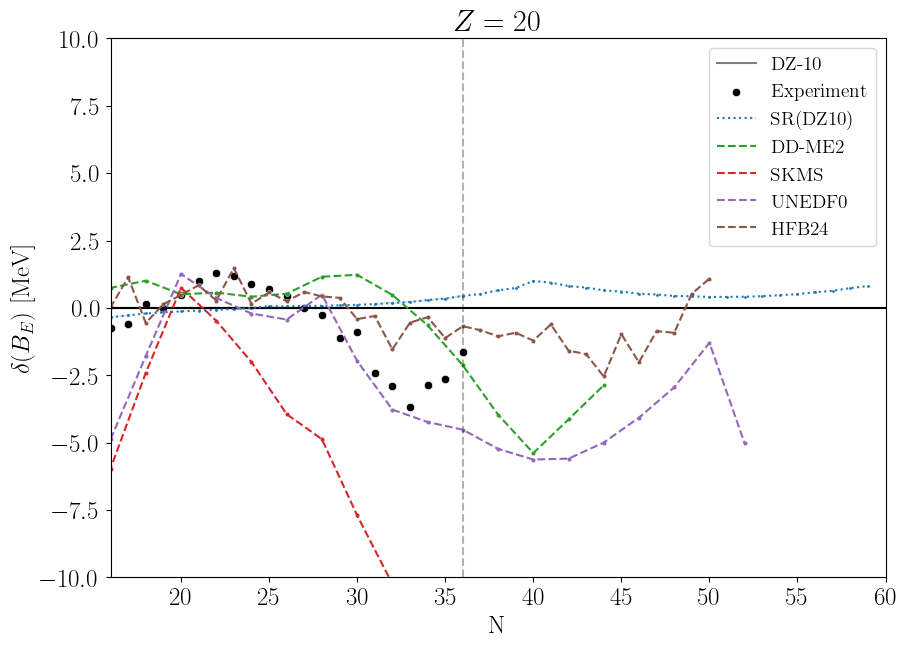

In [41]:
plot_isotope_be(exp_df, models=[sr_dz],
                model_names = ["SR(DZ10)"],
                fixed_z=20, n_max=60)

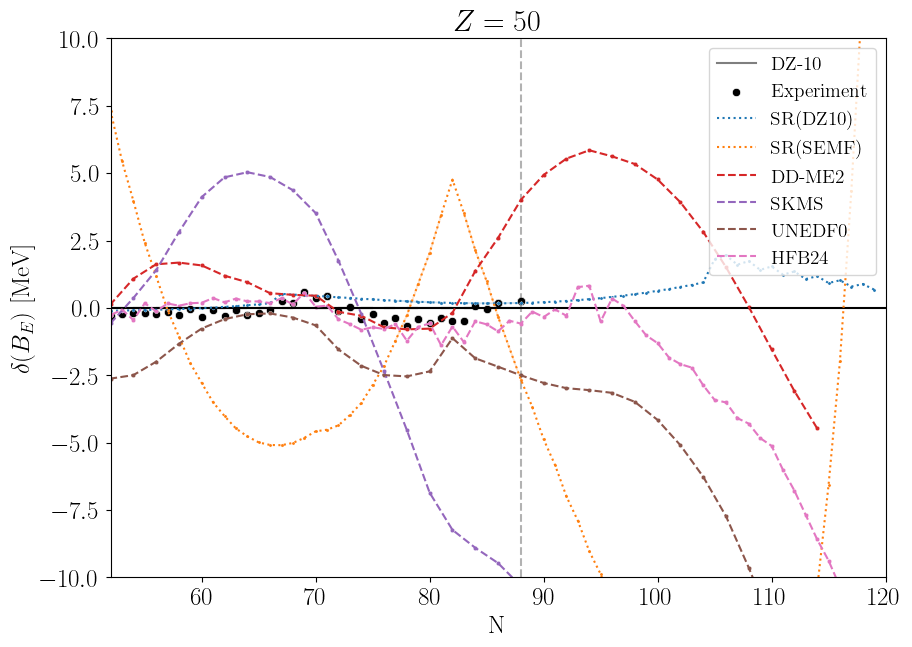

In [18]:
plot_isotope_be(exp_df, models=[sr_dz, sr_semf],
                model_names = ["SR(DZ10)", "SR(SEMF)"],
                fixed_z=50, n_max=120)

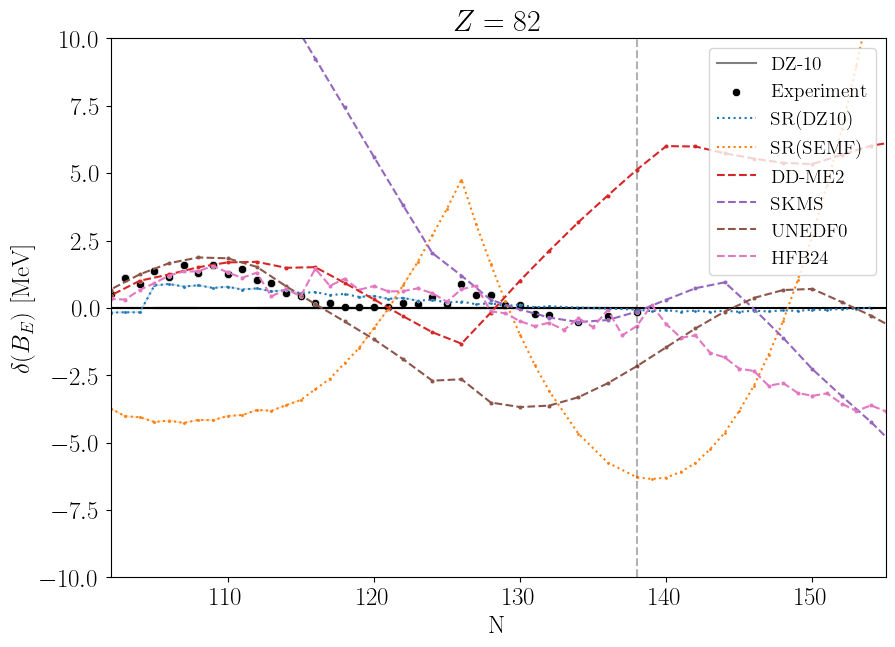

In [19]:
plot_isotope_be(exp_df, models=[sr_dz, sr_semf],
                model_names = ["SR(DZ10)", "SR(SEMF)"],
                fixed_z=82, n_max=155)

ValueError: zero-size array to reduction operation maximum which has no identity

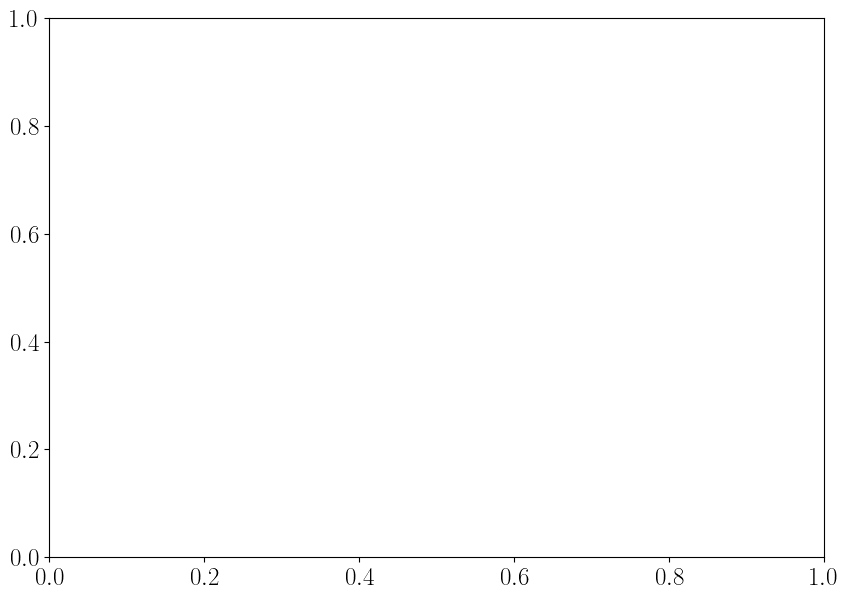

In [29]:
plot_isotope_be(exp_df, models=[sr_dz],
                model_names = ["SR(DZ10)"],
                fixed_z=20, n_max=65)

# Unseen data

In [21]:

full_exp_df = pd.read_excel("../../Data/Theory/MasterNuclei.xlsx", sheet_name="AME2020")


In [22]:
%%capture
full_exp_df["dz_sr_pred"] = full_exp_df.apply(lambda x: sr_dz(x["Z"], x["N"]), axis=1)
full_exp_df["semf_sr_pred"] = full_exp_df.apply(lambda x: sr_semf(x["Z"], x["N"]), axis=1)
full_exp_df["dz"] = full_exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)


/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_23429/671759734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foo_19["dz_sr_pred"] = foo_19.apply(lambda x: sr_dz(x["Z"], x["N"]), axis=1)


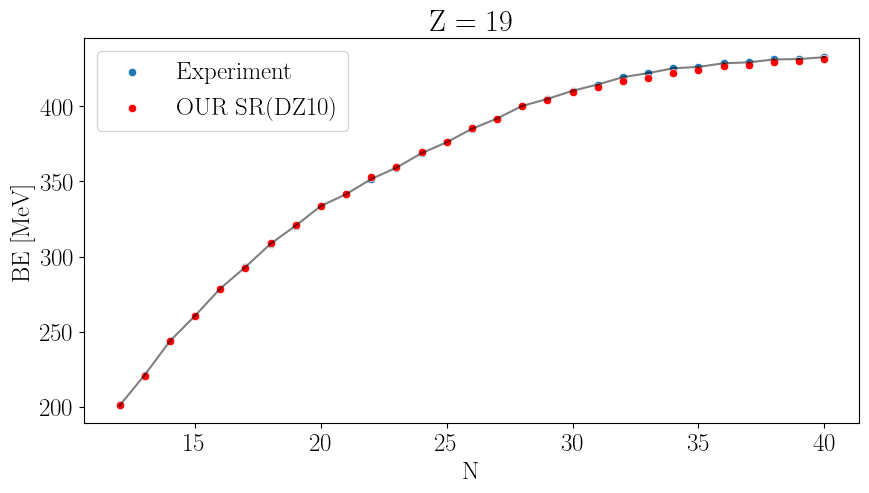

In [23]:
foo_19 = full_exp_df.query("Z==19")
foo_19["dz_sr_pred"] = foo_19.apply(lambda x: sr_dz(x["Z"], x["N"]), axis=1)
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x="N", y="BE", data=foo_19, label="Experiment")
# Uncertainty uBE
plt.errorbar(foo_19["N"], foo_19["BE"], yerr=foo_19["uBE"], color="black", alpha=0.5)
sns.scatterplot(x="N", y="dz_sr_pred", data=foo_19, label="OUR SR(DZ10)", color="red")
ax.set_xlabel("N")
ax.set_ylabel("BE [MeV]")
ax.set_title("Z = 19")
plt.show()

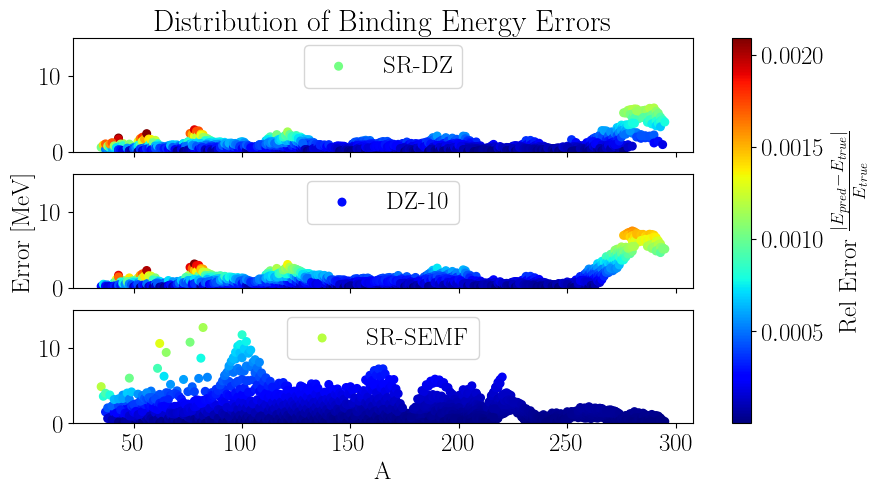

In [24]:
foo_full = full_exp_df.copy().query("Z>20")
regr_error = np.abs((foo_full.dz_sr_pred - foo_full.BE.values))
srsemf_error = np.abs((foo_full.semf_sr_pred - foo_full.BE.values))
dz_error = np.abs((foo_full.dz - foo_full.BE.values))

max_error = np.max([regr_error, dz_error, srsemf_error])

A = foo_full["Z"] + foo_full["N"]
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
for i, (data, label) in enumerate(
    zip([regr_error, dz_error, srsemf_error], ["SR-DZ", "DZ-10", "SR-SEMF"])
):
    rel_error = np.abs(data / foo_full.BE.values)
    g = ax[i].scatter(A, data, c=rel_error / max_error, cmap="jet", s=30, label=label)
    # set location of legend
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    ax[i].set(ylim=(0, 15))
ax[i].set_xlabel("A")
ax[1].set_ylabel("Error [MeV]", rotation=90)

ax[0].set_title("Distribution of Binding Energy Errors")
# Add a colorbar to the figure
ax[0].figure.colorbar(g, ax=ax, label = r"Rel Error $\frac{|E_{pred} - E_{true}|}{E_{true}}$")

In [25]:
full_exp_df

,BE,uBE,N,Z,eBE,dz_sr_pred,semf_sr_pred,dz
0,2.224566,4.000000e-07,1,1,0,2.021075,-14.721761,0.00000
1,8.481796,9.000000e-07,2,1,0,-0.293079,-33.321882,0.00000
2,6.881796,1.000000e-01,3,1,0,-0.097830,207.026444,0.00000
3,6.681796,8.944250e-02,4,1,0,-0.371285,29.598071,0.00000
4,5.769837,2.541270e-01,5,1,0,-0.841225,-35.448425,0.00000
...,...,...,...,...,...,...,...,...
3551,2078.835000,8.790000e-01,176,117,1,2082.895611,2079.339555,2084.17339
3552,2085.048000,5.880000e-01,177,117,1,2089.268901,2085.472411,2090.34177
3553,2073.854000,5.860000e-01,175,118,1,2077.148308,2073.499257,2078.48704
3554,2081.226000,5.880000e-01,176,118,1,2082.164694,2081.337608,2086.33242


In [26]:
def neutron_separation_energy(Z, N, model):
    return model(Z, N) - model(Z, N-1)

def experimental_neutron_separation_energy(Z, N, df = full_exp_df):
    try:
        return df[(df["Z"]==Z) & (df["N"]==N)]["BE"].values[0] - df[(df["Z"]==Z) & (df["N"]==N-1)]["BE"].values[0]
    except:
        return np.nan
    
def experimental_neutron_separation_energy_error(Z, N):
    try:
        return 2*(full_exp_df[(full_exp_df["Z"]==Z) & (full_exp_df["N"]==N)]["uBE"].values[0] + full_exp_df[(full_exp_df["Z"]==Z) & (full_exp_df["N"]==N-1)]["uBE"].values[0])
    except:
        return np.nan

def proton_separation_energy(Z, N, model):
    return model(Z, N) - model(Z-1, N)

def experimental_proton_separation_energy(Z, N, df = full_exp_df):
    try:
        return df[(df["Z"]==Z) & (df["N"]==N)]["BE"].values[0] - df[(df["Z"]==Z-1) & (df["N"]==N)]["BE"].values[0]
    except:
        return np.nan
    
def experimental_proton_separation_error(Z, N):
    try:
        return 2*(full_exp_df[(full_exp_df["Z"]==Z) & (full_exp_df["N"]==N)]["uBE"].values[0] + full_exp_df[(full_exp_df["Z"]==Z-1) & (full_exp_df["N"]==N)]["uBE"].values[0])
    except:
        return np.nan

Z=8, N=0 not found in precomputed data
Z=7, N=0 not found in precomputed data
Z=8, N=1 not found in precomputed data
Z=7, N=1 not found in precomputed data
Z=7, N=2 not found in precomputed data
Z=8, N=0 not found in precomputed data
Z=7, N=0 not found in precomputed data
Z=8, N=1 not found in precomputed data
Z=7, N=1 not found in precomputed data
Z=7, N=2 not found in precomputed data
Z=9, N=0 not found in precomputed data
Z=8, N=0 not found in precomputed data
Z=9, N=1 not found in precomputed data
Z=8, N=1 not found in precomputed data
Z=9, N=2 not found in precomputed data
Z=9, N=0 not found in precomputed data
Z=8, N=0 not found in precomputed data
Z=9, N=1 not found in precomputed data
Z=8, N=1 not found in precomputed data
Z=9, N=2 not found in precomputed data


/Users/jose/Documents/Works/MIT/AI/PyMassModels/notebooks/test/../../nuclearpy_models/models/BE/sr.py:129: RuntimeWarning: invalid value encountered in double_scalars
  (((P + P) / N) - I)
/Users/jose/Documents/Works/MIT/AI/PyMassModels/notebooks/test/../../nuclearpy_models/models/BE/sr.py:129: RuntimeWarning: divide by zero encountered in double_scalars
  (((P + P) / N) - I)


Text(0.5, 0.98, 'Proton Separation Energy')

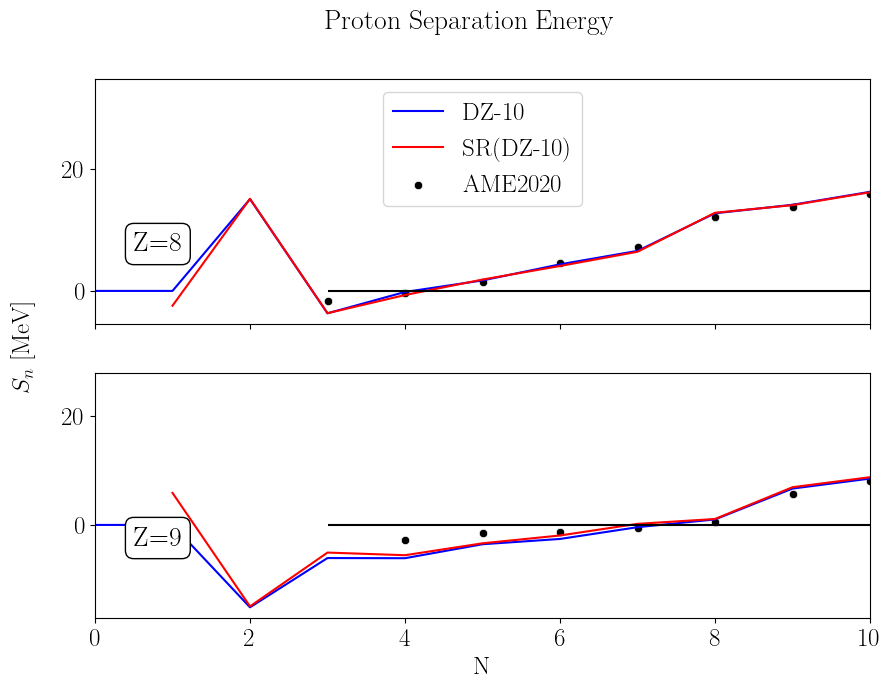

In [27]:
all_ns = np.arange(0, 25)

def get_predictions(model, Z, f= neutron_separation_energy):
    return np.array([f(Z, n, model) for n in all_ns])

all_preds_dz_8 = get_predictions(dz_be, 8, proton_separation_energy)
all_preds_sr_8 = get_predictions(sr_dz, 8, proton_separation_energy)
all_exp_8 = np.array([experimental_proton_separation_energy(8, n) for n in all_ns])
all_errors_8 = np.array([experimental_proton_separation_error(8, n) for n in all_ns])


all_preds_dz_9 = get_predictions(dz_be, 9, proton_separation_energy)
all_preds_sr_9 = get_predictions(sr_dz, 9, proton_separation_energy)

all_exp_9 = np.array([experimental_proton_separation_energy(9, n) for n in all_ns])
all_errors_9 = np.array([experimental_proton_separation_error(9, n) for n in all_ns])

fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

# Use grid spec to set the spacing between the two plots

sns.lineplot(x=all_ns, y=all_preds_dz_8, label="DZ-10", color="blue", ax=ax[0])
sns.lineplot(x=all_ns, y=all_preds_sr_8, label="SR(DZ-10)", color="red", ax=ax[0])

sns.scatterplot(x=all_ns, y=all_exp_8, label="AME2020", color="black", ax=ax[0])
# Put error bars to the scatter plot
#ax[0].errorbar(all_ns, all_exp_preds_8[all_errors_8!=np.nan], yerr=all_errors_8[all_errors_8!=np.nan], color="black", linestyle="None",
#                elinewidth=1, capsize=2, capthick=1, alpha=1.
#)   
ax[0].hlines(0, 3, 25, color="black", linestyle="-")
#ax[0].set(ylim=(, 40))
# Annotate Z=8
ax[0].annotate(
    "Z=8",
    xy=(0.05, 0.3),
    xycoords="axes fraction",
    fontsize=20,
    bbox=dict(boxstyle="round", fc="white", ec="black"),
)

sns.lineplot(x=all_ns, y=all_preds_dz_9,    color="blue", ax=ax[1])
sns.lineplot(x=all_ns, y=all_preds_sr_9, color="red", ax=ax[1])

sns.scatterplot(x=all_ns, y=all_exp_9, color="black", ax=ax[1])
# Put error bars to the scatter plot
#plt.errorbars(all_ns, all_exp_preds_9[all_errors_9!=np.nan], yerr=all_errors_9[all_errors_9!=np.nan], color="black", linestyle="None",
#                elinewidth=1, capsize=2, capthick=1, alpha=1.
#)
ax[1].hlines(0, 3, 25, color="black", linestyle="-")
ax[1].set(xlabel="N")#, xlim=(2, 25)#), ylim=(-3, 30))
ax[1].annotate(
    "Z=9",
    xy=(0.05, 0.3),
    xycoords="axes fraction",
    fontsize=20,
    bbox=dict(boxstyle="round", fc="white", ec="black"),
)
ax[0].set(xlim=(0,10))
ax[1].set(xlim=(0,10))

# Put one single ylabel for both plots
fig.text(0.04, 0.5, r"$S_n$ [MeV]", va="center", rotation="vertical")
fig.suptitle("Proton Separation Energy", fontsize=20)

Z=20, N=3 not found in precomputed data
Z=20, N=2 not found in precomputed data
Z=20, N=4 not found in precomputed data
Z=20, N=3 not found in precomputed data
Z=20, N=5 not found in precomputed data
Z=20, N=4 not found in precomputed data
Z=20, N=6 not found in precomputed data
Z=20, N=5 not found in precomputed data
Z=20, N=7 not found in precomputed data
Z=20, N=6 not found in precomputed data
Z=20, N=8 not found in precomputed data
Z=20, N=7 not found in precomputed data
Z=20, N=8 not found in precomputed data
Z=20, N=3 not found in precomputed data
Z=20, N=2 not found in precomputed data
Z=20, N=4 not found in precomputed data
Z=20, N=3 not found in precomputed data
Z=20, N=5 not found in precomputed data
Z=20, N=4 not found in precomputed data
Z=20, N=6 not found in precomputed data
Z=20, N=5 not found in precomputed data
Z=20, N=7 not found in precomputed data
Z=20, N=6 not found in precomputed data
Z=20, N=8 not found in precomputed data
Z=20, N=7 not found in precomputed data


Text(0.5, 0.98, 'Neutron Separation Energy')

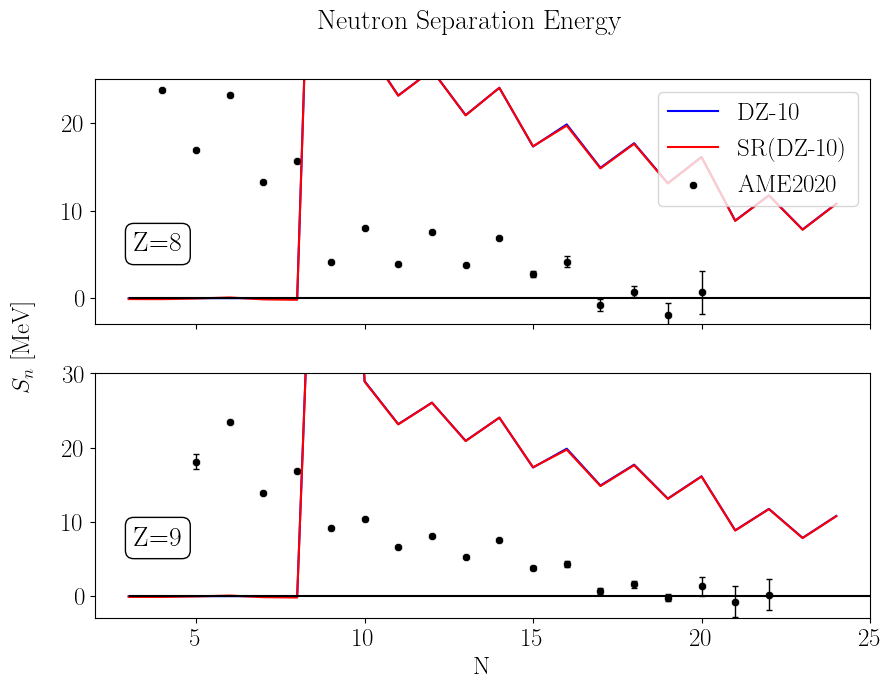

In [43]:
all_ns = np.arange(3, 25)

all_preds_dz_8 = get_predictions(dz_be, 20)
all_preds_sr_8 = get_predictions(sr_dz, 20)
all_preds_dz_9 = get_predictions(dz_be, 20)
all_preds_sr_9 = get_predictions(sr_dz, 20)

all_exp_preds_8 = np.array([experimental_neutron_separation_energy(8, n) for n in all_ns])
all_exp_errors_8 = np.array([experimental_neutron_separation_energy_error(8, n) for n in all_ns])
all_exp_errors_8 = np.nan_to_num(all_exp_errors_8)
all_exp_preds_9 = np.array([experimental_neutron_separation_energy(9, n) for n in all_ns])
all_exp_errors_9 = np.array([experimental_neutron_separation_energy_error(9, n) for n in all_ns])
all_exp_errors_9 = np.nan_to_num(all_exp_errors_9)

fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

sns.lineplot(x=all_ns, y=all_preds_dz_8, label="DZ-10", color="blue", ax=ax[0])
sns.lineplot(x=all_ns, y=all_preds_sr_8, label="SR(DZ-10)", color="red", ax=ax[0])
sns.scatterplot(x=all_ns, y=all_exp_preds_8, label="AME2020", color="black", ax=ax[0])
# Put error bars to the scatter plot
ax[0].errorbar(all_ns, all_exp_preds_8[all_exp_errors_8!=np.nan], yerr=all_exp_errors_8, color="black", linestyle="None",
                elinewidth=1, capsize=2, capthick=1, alpha=1.
)   

ax[0].hlines(0, 3, 25, color="black", linestyle="-")
ax[0].set(ylim=(-3, 25))
# Annotate Z=8
ax[0].annotate(
    "Z=8",
    xy=(0.05, 0.3),
    xycoords="axes fraction",
    fontsize=20,
    bbox=dict(boxstyle="round", fc="white", ec="black"),
)

sns.lineplot(x=all_ns, y=all_preds_dz_9,    color="blue", ax=ax[1])
sns.lineplot(x=all_ns, y=all_preds_sr_9, color="red", ax=ax[1])
sns.scatterplot(x=all_ns, y=all_exp_preds_9, color="black", ax=ax[1])
ax[1].errorbar(all_ns, all_exp_preds_9[all_exp_errors_9!=np.nan], yerr=all_exp_errors_9, color="black", linestyle="None",
                               elinewidth=1, capsize=2, capthick=1, alpha=1.
)   

ax[1].hlines(0, 3, 25, color="black", linestyle="-")
ax[1].set(xlabel="N", xlim=(2, 25), ylim=(-3, 30))
ax[1].annotate(
    "Z=9",
    xy=(0.05, 0.3),
    xycoords="axes fraction",
    fontsize=20,
    bbox=dict(boxstyle="round", fc="white", ec="black"),
)
# Put one single ylabel for both plots
fig.text(0.04, 0.5, r"$S_n$ [MeV]", va="center", rotation="vertical")
fig.suptitle("Neutron Separation Energy", fontsize=20)

Z=8, N=0 not found in precomputed data
Z=8, N=-1 not found in precomputed data
Z=8, N=1 not found in precomputed data
Z=8, N=0 not found in precomputed data
Z=8, N=1 not found in precomputed data
Z=8, N=27 not found in precomputed data
Z=8, N=28 not found in precomputed data
Z=8, N=27 not found in precomputed data
Z=8, N=29 not found in precomputed data
Z=8, N=28 not found in precomputed data
Z=8, N=30 not found in precomputed data
Z=8, N=29 not found in precomputed data
Z=8, N=31 not found in precomputed data
Z=8, N=30 not found in precomputed data
Z=8, N=32 not found in precomputed data
Z=8, N=31 not found in precomputed data
Z=8, N=33 not found in precomputed data
Z=8, N=32 not found in precomputed data
Z=8, N=34 not found in precomputed data
Z=8, N=33 not found in precomputed data
Z=8, N=35 not found in precomputed data
Z=8, N=34 not found in precomputed data
Z=8, N=36 not found in precomputed data
Z=8, N=35 not found in precomputed data
Z=8, N=37 not found in precomputed data
Z=8,

/Users/jose/Documents/Works/MIT/AI/PyMassModels/notebooks/test/../../nuclearpy_models/models/BE/sr.py:129: RuntimeWarning: invalid value encountered in double_scalars
  (((P + P) / N) - I)
/Users/jose/Documents/Works/MIT/AI/PyMassModels/notebooks/test/../../nuclearpy_models/models/BE/sr.py:129: RuntimeWarning: divide by zero encountered in double_scalars
  (((P + P) / N) - I)


Text(0.5, 0.98, 'Neutron Separation Energy')

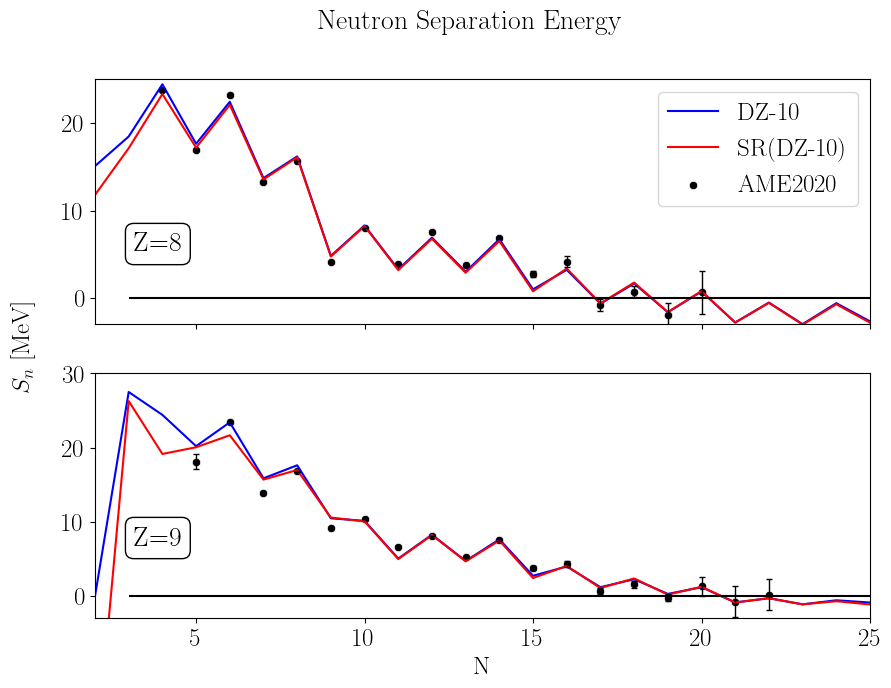

In [ ]:
all_ns = np.arange(40)

all_preds_dz_8 = get_predictions(dz_be, 8)
all_preds_sr_8 = get_predictions(sr_dz, 8)

all_preds_dz_9 = get_predictions(dz_be, 9)
all_preds_sr_9 = get_predictions(sr_dz, 9)

all_exp_preds_8 = np.array([experimental_neutron_separation_energy(8, n) for n in all_ns])
all_exp_errors_8 = np.array([experimental_neutron_separation_energy_error(8, n) for n in all_ns])
all_exp_errors_8 = np.nan_to_num(all_exp_errors_8)
all_exp_preds_9 = np.array([experimental_neutron_separation_energy(9, n) for n in all_ns])
all_exp_errors_9 = np.array([experimental_neutron_separation_energy_error(9, n) for n in all_ns])
all_exp_errors_9 = np.nan_to_num(all_exp_errors_9)

fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

sns.lineplot(x=all_ns, y=all_preds_dz_8, label="DZ-10", color="blue", ax=ax[0])
sns.lineplot(x=all_ns, y=all_preds_sr_8, label="SR(DZ-10)", color="red", ax=ax[0])
sns.scatterplot(x=all_ns, y=all_exp_preds_8, label="AME2020", color="black", ax=ax[0])
# Put error bars to the scatter plot
ax[0].errorbar(all_ns, all_exp_preds_8[all_exp_errors_8!=np.nan], yerr=all_exp_errors_8, color="black", linestyle="None",
                elinewidth=1, capsize=2, capthick=1, alpha=1.
)   

ax[0].hlines(0, 3, 25, color="black", linestyle="-")
ax[0].set(ylim=(-3, 25))
# Annotate Z=8
ax[0].annotate(
    "Z=8",
    xy=(0.05, 0.3),
    xycoords="axes fraction",
    fontsize=20,
    bbox=dict(boxstyle="round", fc="white", ec="black"),
)

sns.lineplot(x=all_ns, y=all_preds_dz_9,    color="blue", ax=ax[1])
sns.lineplot(x=all_ns, y=all_preds_sr_9, color="red", ax=ax[1])
sns.scatterplot(x=all_ns, y=all_exp_preds_9, color="black", ax=ax[1])
ax[1].errorbar(all_ns, all_exp_preds_9[all_exp_errors_9!=np.nan], yerr=all_exp_errors_9, color="black", linestyle="None",
                               elinewidth=1, capsize=2, capthick=1, alpha=1.
)   

ax[1].hlines(0, 3, 25, color="black", linestyle="-")
ax[1].set(xlabel="N", xlim=(2, 25), ylim=(-3, 30))
ax[1].annotate(
    "Z=9",
    xy=(0.05, 0.3),
    xycoords="axes fraction",
    fontsize=20,
    bbox=dict(boxstyle="round", fc="white", ec="black"),
)
# Put one single ylabel for both plots
fig.text(0.04, 0.5, r"$S_n$ [MeV]", va="center", rotation="vertical")
fig.suptitle("Neutron Separation Energy", fontsize=20)

In [ ]:
%%capture
exp_df["n_sep_e"] = exp_df.apply(lambda x: neutron_separation_energy(x["Z"], x["N"], sr_dz), axis=1)
exp_df = exp_df.dropna()


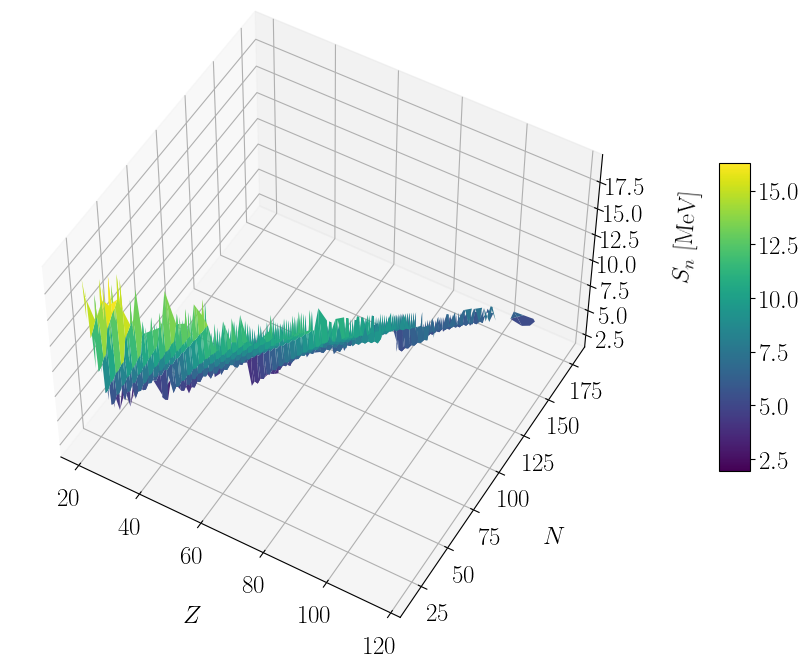

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Create a pivot table with 'N' and 'Z' as indices and 'n_sep_e' as values
pivot_table = exp_df.pivot_table('n_sep_e', 'N', 'Z')

# Convert the pivot table into a matrix
X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)
Z = pivot_table.values

fig = plt.figure(figsize=(12, 8))  # Increase figure size
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

# Adjust label positions and orientations
ax.set_xlabel(r'$Z$', labelpad=20)  # Increase labelpad to move label away from axis
ax.set_ylabel(r'$N$', labelpad=20)
ax.set_zlabel('$S_n$ [MeV]', labelpad=20)
ax.view_init(elev=50, azim=-60)  # Adjust the viewing angle

plt.show()

## Two neutron separation energy

In [ ]:
def two_neutron_separation_energy(Z, N, model):
    return model(Z, N) - model(Z, N-2)

def experimental_two_neutron_separation_energy(Z, N):
    try:
        return full_exp_df[(full_exp_df["Z"]==Z) & (full_exp_df["N"]==N)]["BE"].values[0] - full_exp_df[(full_exp_df["Z"]==Z) & (full_exp_df["N"]==N-2)]["BE"].values[0]
    except:
        return np.nan
    
def experimental_two_neutron_separation_energy_error(Z, N):
    try:
        return 2*(full_exp_df[(full_exp_df["Z"]==Z) & (full_exp_df["N"]==N)]["uBE"].values[0] + full_exp_df[(full_exp_df["Z"]==Z) & (full_exp_df["N"]==N-2)]["uBE"].values[0])
    except:
        return np.nan

Caption to replicate:

Two-neutron separation energies, S 2n , along Ar, K, Ca, Sc and Ti isotopic chains. The experimental values (isolated symbols) [78, 79, 80] are compared to predictions for the full 3NF Hamiltonian with a SRG cutoff of λ SRG = 2.0 fm −1 (full lines). Results are for second order Gorkov calculations and the values for K, Ca, Sc and Ti are respectively shifted by +5 MeV, 10 MeV, 15 MeV and 20 MeV for display purposes. From Ref.

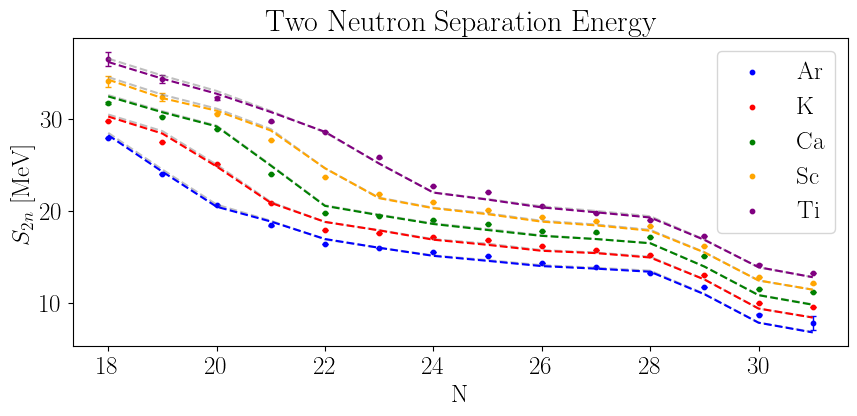

In [ ]:
Ar_Z = 18
K_Z = 19
Ca_Z = 20
Sc_Z = 21
Ti_Z = 22

sz = [Ar_Z, K_Z, Ca_Z, Sc_Z, Ti_Z]
names = ["Ar", "K", "Ca", "Sc", "Ti"]
colors = ["blue", "red", "green", "orange", "purple"]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
all_ns = np.arange(18, 32)

for (z, color, name) in zip(sz, colors, names):
    all_preds_dz = get_predictions(dz_be, z, f=two_neutron_separation_energy)
    all_preds_sr = get_predictions(sr_dz, z, f=two_neutron_separation_energy)
    all_exp_vals = np.array([experimental_two_neutron_separation_energy(z, n) for n in all_ns])
    all_exp_errors = np.array([experimental_two_neutron_separation_energy_error(z, n) for n in all_ns])
    all_exp_errors = np.nan_to_num(all_exp_errors)
    ax.errorbar(all_ns, all_exp_vals, yerr=all_exp_errors, color=color, linestyle="None",
                               elinewidth=1, capsize=2, capthick=1, alpha=1.)
    
    
    ax.plot(all_ns, all_preds_dz, label=None, color="grey", linestyle="--", alpha=0.5)
    ax.plot(all_ns, all_preds_sr, label=None, color=color, linestyle="--")
    ax.scatter(all_ns, all_exp_vals, label=f"{name}", color=color, s=10)
    ax.set(xlabel="N", ylabel=r"$S_{2n}$ [MeV]", title="Two Neutron Separation Energy")
    
# Put one label for each element

ax.legend()

NameError: name 'two_neutron_separation_energy' is not defined

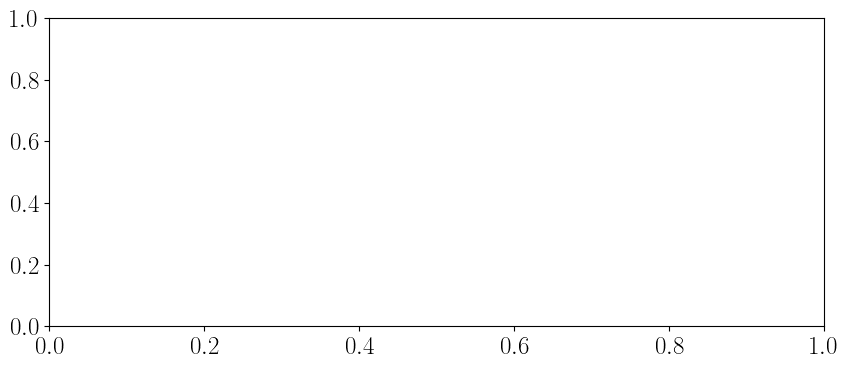

In [42]:
Ca_Z = 20

sz = [Ca_Z]
names = ["Ca"]
colors = ["blue"]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
all_ns = np.arange(18, 32)

for (z, color, name) in zip(sz, colors, names):
    all_preds_dz = get_predictions(dz_be, z, f=two_neutron_separation_energy)
    all_preds_sr = get_predictions(sr_dz, z, f=two_neutron_separation_energy)
    all_exp_vals = np.array([experimental_two_neutron_separation_energy(z, n) for n in all_ns])
    all_exp_errors = np.array([experimental_two_neutron_separation_energy_error(z, n) for n in all_ns])
    all_exp_errors = np.nan_to_num(all_exp_errors)
    ax.errorbar(all_ns, all_exp_vals, yerr=all_exp_errors, color=color, linestyle="None",
                               elinewidth=1, capsize=2, capthick=1, alpha=1.)
    
    
    ax.plot(all_ns, all_preds_dz, label=None, color="grey", linestyle="--", alpha=0.5)
    ax.plot(all_ns, all_preds_sr, label=None, color=color, linestyle="--")
    ax.scatter(all_ns, all_exp_vals, label=f"{name}", color=color, s=10)
    ax.set(xlabel="N", ylabel=r"$S_{2n}$ [MeV]", title="Two Neutron Separation Energy")
    
# Put one label for each element

ax.legend()

/Users/jose/Documents/Works/MIT/AI/PyMassModels/notebooks/test/../../nuclearpy_models/models/BE/sr.py:129: RuntimeWarning: divide by zero encountered in double_scalars
  (((P + P) / N) - I)


Z=4.0, N=0.0 not found in precomputed data
Z=5.0, N=0.0 not found in precomputed data
Z=7.0, N=2.0 not found in precomputed data
Z=7.0, N=2.0 not found in precomputed data


KeyError: 'Z'

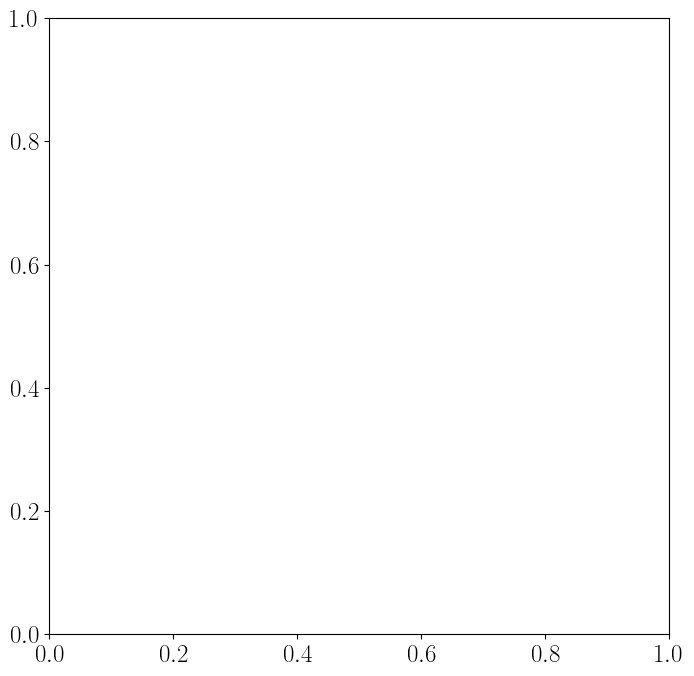

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fpp = full_exp_df.copy().query("Z>3").query("Z<=10")
fpp["n_sep_e"] = fpp.apply(lambda x: neutron_separation_energy(x["Z"], x["N"], sr_dz), axis=1)
fpp = fpp.dropna(subset=["n_sep_e"])
fpp["exp_sep"] = fpp.apply(lambda x: experimental_neutron_separation_energy(x["Z"], x["N"]), axis=1)
# filter the ones marked with "-inf"
fpp = fpp[fpp.n_sep_e.apply(lambda x: np.isfinite(x))]
fpp["rel_error"] = fpp.apply(lambda x: np.abs(fpp.apply(lambda x: neutron_separation_energy(x["Z"], x["N"], sr_dz), axis=1) -fpp.apply(lambda x: experimental_neutron_separation_energy(x["Z"], x["N"]))), axis=1)
#fpp["rel_error"] = fpp["rel_error"] / fpp["n_sep_e"]
marker_size = 10#(np.abs(fpp["rel_error"])+0.02)*30

g = ax.scatter(fpp["N"], fpp["Z"], c=fpp["rel_error"], s=marker_size, cmap="jet")
plt.colorbar(g, label = r"Rel. Error $\frac{|SR - S_n|}{S_n}$")


# Put lines at the edges of the nuclei
#ax.hlines(n_protons, 15, fpp["N"].max(), color="grey", linestyle="--", alpha=0.4)
#ax.vlines(n_neutrons, 15, fpp["Z"].max(), color="grey", linestyle="--", alpha=0.4)

ax.set_xlabel("$N$", fontsize=20)
ax.set_ylabel("$Z$", rotation=90, fontsize=20)
ax.legend(loc='upper right', fontsize=10)

plt.title('Relative Errors in Neutron Separation Energy', fontsize=20)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


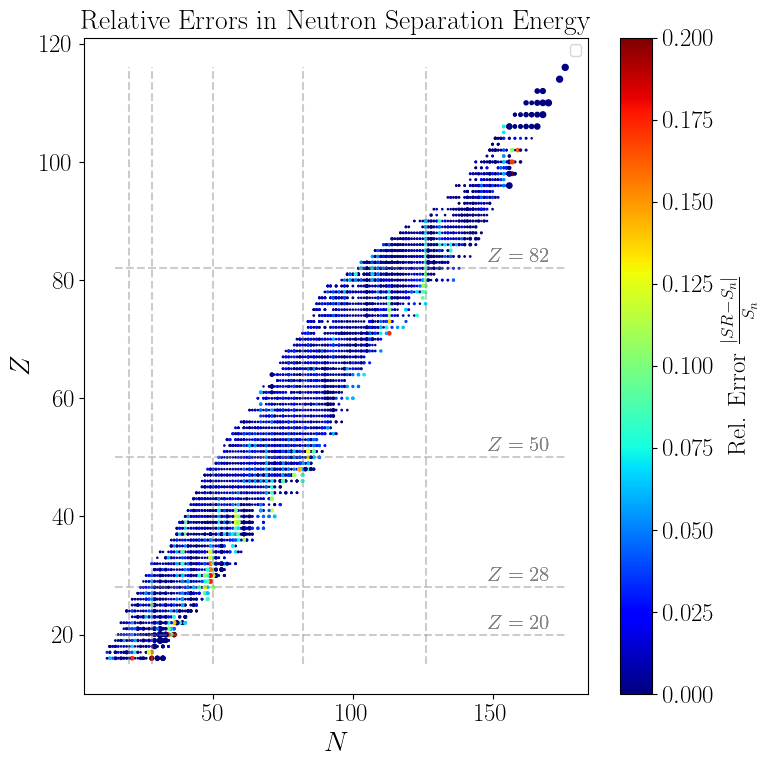

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

fpp = pd.read_csv('../../Data/Experimental/be_exp.csv', delimiter=',').copy().query("Z>15")
fpp["n_sep_e"] = fpp.apply(lambda x: neutron_separation_energy(x["Z"], x["N"], sr_dz), axis=1)
fpp = fpp.dropna()
fpp["rel_error"] = fpp.apply(lambda x: x["n_sep_e"] - experimental_neutron_separation_energy(x["Z"], x["N"]), axis=1) / fpp["n_sep_e"]

# Set a consistent marker size
marker_size = (np.abs(fpp["rel_error"])+0.02)*30

g = ax.scatter(fpp["N"], fpp["Z"], c=fpp["rel_error"], s=marker_size, cmap="jet", vmin=0.0, vmax=0.2)
plt.colorbar(g, label = r"Rel. Error $\frac{|SR - S_n|}{S_n}$")

n_protons = [20, 28, 50, 82]
n_neutrons = [ 20, 28, 50, 82, 126]

# Put lines at the edges of the nuclei
ax.hlines(n_protons, 15, fpp["N"].max(), color="grey", linestyle="--", alpha=0.4)
ax.vlines(n_neutrons, 15, fpp["Z"].max(), color="grey", linestyle="--", alpha=0.4)

# Annotate the magic numbers
for num in n_protons + n_neutrons:
    ax.annotate(f'$Z ={num}$', (fpp["N"].max()-5, num + 1), color='grey', fontsize=15, ha='right')

ax.set_xlabel("$N$", fontsize=20)
ax.set_ylabel("$Z$", rotation=90, fontsize=20)
ax.legend(loc='upper right', fontsize=10)

plt.title('Relative Errors in Neutron Separation Energy', fontsize=20)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


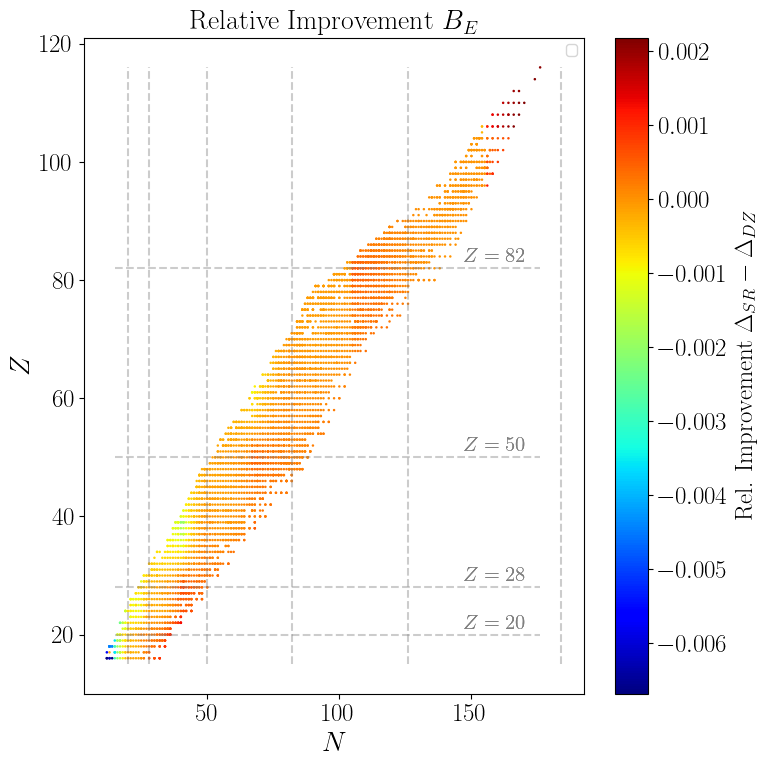

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fpp = pd.read_csv('../../Data/Experimental/be_exp.csv', delimiter=',').copy().query("Z>15")
fpp["sr_dz"] = fpp.apply(lambda x: sr_dz(x["Z"], x["N"]), axis=1)
fpp["dz"] = fpp.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)

# Metric for improvement relative to 'BE'
fpp["rel_error_sr"] = fpp.apply(lambda x: (x["sr_dz"] - x["BE"]) / x["BE"], axis=1)
fpp["rel_error_dz"] = fpp.apply(lambda x: (x["dz"] - x["BE"]) / x["BE"], axis=1)

fpp = fpp.dropna()
fpp["improvement"] = fpp.apply(lambda x: x["rel_error_dz"] - x["rel_error_sr"], axis=1)
# Set a consistent marker size
marker_size = (np.abs(fpp["improvement"])+0.02)*30

g = ax.scatter(fpp["N"], fpp["Z"], c=fpp["improvement"], s=marker_size, cmap="jet")
plt.colorbar(g, label = r"Rel. Improvement $\Delta_{SR} - \Delta_{DZ}$")

n_protons = [20, 28, 50, 82]
n_neutrons = [ 20, 28, 50, 82, 126, 184]

# Put lines at the edges of the nuclei
ax.hlines(n_protons, 15, fpp["N"].max(), color="grey", linestyle="--", alpha=0.4)
ax.vlines(n_neutrons, 15, fpp["Z"].max(), color="grey", linestyle="--", alpha=0.4)

# Annotate the magic numbers
for num in n_protons + n_neutrons:
    ax.annotate(f'$Z ={num}$', (fpp["N"].max()-5, num + 1), color='grey', fontsize=15, ha='right')

ax.set_xlabel("$N$", fontsize=20)
ax.set_ylabel("$Z$", rotation=90, fontsize=20)
ax.legend(loc='upper right', fontsize=10)

plt.title('Relative Improvement $B_E$', fontsize=20)
plt.tight_layout()
plt.show()